In [ ]:
import matplotlib.pyplot as plt
import os
import torch 
from torch.utils.data import DataLoader
import json
import sys
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

sys.path.append("src")
os.chdir('/home/george-vengrovski/Documents/projects/tweety_bert_paper')

from data_class import SongDataSet_Image, CollateFunction
from model import TweetyBERT
from analysis import plot_umap_projection
from utils import detailed_count_parameters, load_weights, load_model


weights_path = "/home/george-vengrovski/Documents/projects/tweety_bert_paper/experiments/llb3_train_500/saved_weights/model_step_19998.pth"
config_path = "/home/george-vengrovski/Documents/projects/tweety_bert_paper/experiments/llb3_train_500/config.json"

tweety_bert_model = load_model(config_path, weights_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tweety_bert_model = tweety_bert_model.to(device)

In [ ]:
from torch.utils.data import DataLoader
from data_class import SongDataSet_Image

train_dir = "/home/george-vengrovski/Documents/projects/tweety_bert_paper/files/llb3_train_25"
test_dir = "/home/george-vengrovski/Documents/projects/tweety_bert_paper/files/llb3_test_25"

train_dataset = SongDataSet_Image(train_dir, num_classes=21, psuedo_labels_generated=False)
test_dataset = SongDataSet_Image(test_dir, num_classes=21, psuedo_labels_generated=False)

collate_fn = CollateFunction(segment_length=1000)  # Adjust the segment length if needed

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

## Heatmap for each attention connection for each label

100%|██████████| 10/10 [01:26<00:00,  8.68s/it]


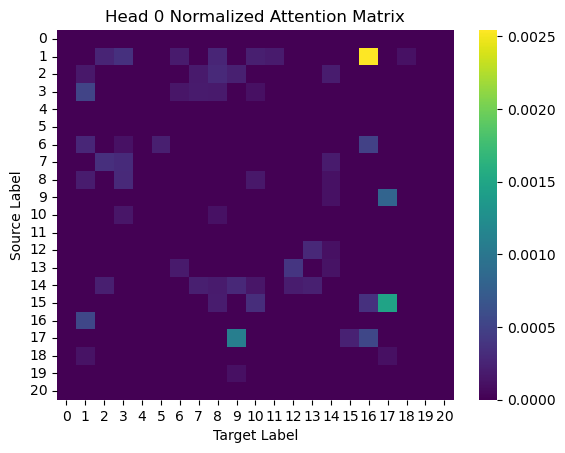

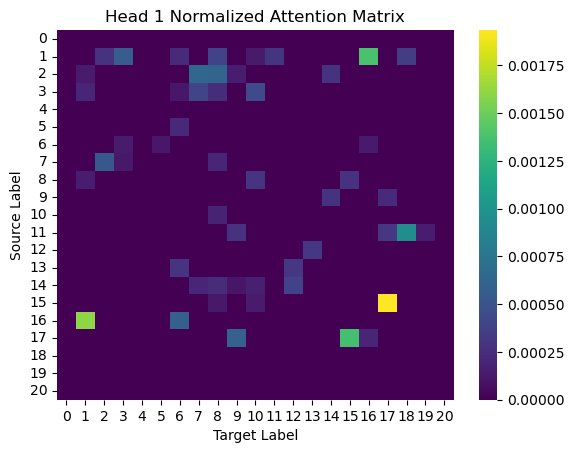

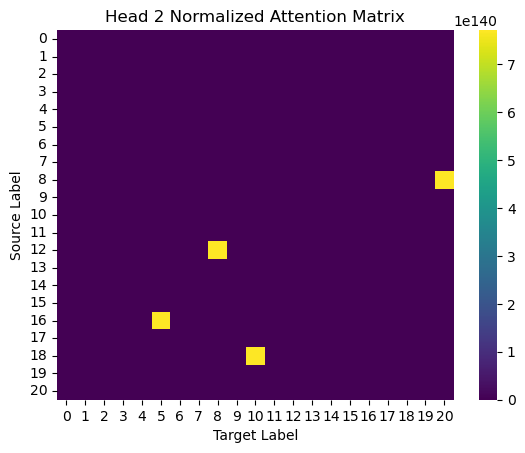

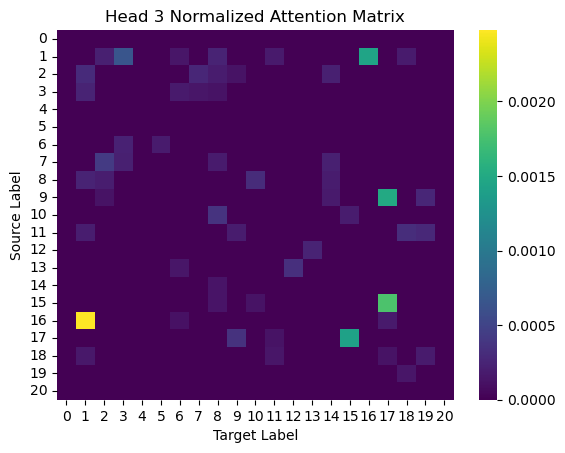

In [103]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm

desired_total_batches = 10

# Initialize attention matrices for each head
attention_matrices = []
label_count_matrices = []

# Assuming num_heads is known or can be obtained from the model
# Here, just a placeholder value; replace with actual number of heads
num_heads_placeholder = 4
num_labels = None  # This will be set based on the label shape
layer = 3

# Initialize attention and count matrices
for _ in range(num_heads_placeholder):
    attention_matrices.append(None)
    label_count_matrices.append(None)

with tqdm(total=desired_total_batches) as pbar:
    total_batches = 0

    while total_batches < desired_total_batches:
        for i, (spectrogram, label, _) in enumerate(test_loader):
            if total_batches >= desired_total_batches:
                break

            output, layers = tweety_bert_model.inference_forward(spectrogram.to(device))
            total_batches += 1
            pbar.update(1)

            # Extract attention weights
            attention_weights = layers[layer]["attention_graph"].detach().cpu().numpy()

            # Map tokens to labels
            token_to_label = label.argmax(dim=-1).cpu().numpy()

            if num_labels is None:
                num_labels = label.shape[-1]

                # Initialize matrices now that num_labels is known
                for head in range(num_heads_placeholder):
                    attention_matrices[head] = np.zeros((num_labels, num_labels))
                    label_count_matrices[head] = np.zeros((num_labels, num_labels))

            # Process each head
            for head in range(num_heads_placeholder):
                # Vectorized computation for attention aggregation
                for b in range(attention_weights.shape[0]):  # batch
                    for src_label in range(num_labels):
                        for tgt_label in range(num_labels):
                            # Create masks
                            src_mask = (token_to_label[b] == src_label)
                            tgt_mask = (token_to_label[b] == tgt_label)
                            combined_mask = src_mask[:, np.newaxis] * tgt_mask[np.newaxis, :]
                            
                            # Aggregate attention weights and count occurrences
                            attention_matrices[head][src_label, tgt_label] += np.sum(
                                attention_weights[b, head, :, :] * combined_mask
                            )
                            label_count_matrices[head][src_label, tgt_label] += np.sum(combined_mask)

#### Save JSON and PLOT ####

# Directory for saving results
save_dir = "results/attention_matrix"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Normalize, plot, and save the attention matrices
# Also removes diagnol and 0 column and row 
threshold = 1e-4  # Set values below this threshold to zero
for head in range(num_heads_placeholder):
    # Normalize the attention matrix
    normalized_matrix = np.divide(
        attention_matrices[head], 
        label_count_matrices[head], 
        where=label_count_matrices[head] != 0
    )

    # Apply threshold
    normalized_matrix = np.where(normalized_matrix < threshold, 0, normalized_matrix)
    normalized_matrix = np.where(np.isnan(normalized_matrix), 0, normalized_matrix)

    # Zero out the diagonal
    np.fill_diagonal(normalized_matrix, 0)

    # Zero out rows and columns for label '0'
    normalized_matrix[0, :] = 0
    normalized_matrix[:, 0] = 0

    ## Plot the matrix
    fig, ax = plt.subplots()
    sns.heatmap(normalized_matrix, annot=False, fmt=".2f", ax=ax, cmap="viridis", vmin=0)
    ax.set_title(f'Head {head} Normalized Attention Matrix')
    ax.set_xlabel('Target Label')
    ax.set_ylabel('Source Label')
    plt.show()

    # Convert the entire matrix to a list of lists
    matrix_list = normalized_matrix.tolist()

    # Save the matrix as a JSON file
    save_path = os.path.join(save_dir, f"layer_{layer}_head_{head}.json")
    with open(save_path, 'w') as file:
        json.dump(matrix_list, file)

## Calculations of Coccurence Matrix as Well as Random Perumations of Co-occurence Matrix

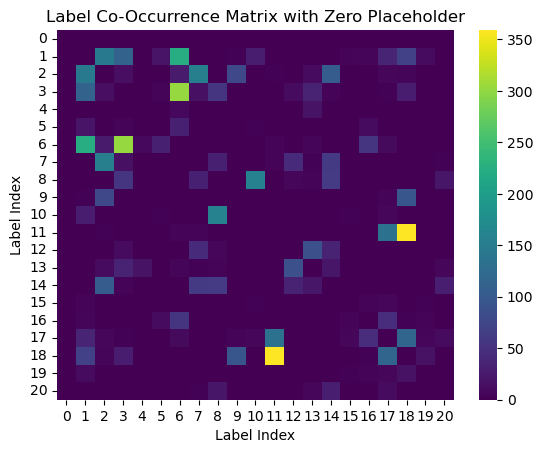

In [104]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming train_loader is defined and num_labels is known
num_labels = 21  # original number of labels including '0' label
co_occurrence_matrix = np.zeros((num_labels, num_labels))  # expanded matrix size

# Process the data
for _, (_, label, _) in enumerate(train_loader):
    # Convert one-hot encoded labels to label indices
    label_indices = np.argmax(label.numpy(), axis=-1)

    for label_seq in label_indices:
        # Remove label 0
        no_zero_label_seq = [k for k in label_seq if k != 0]

        # Compress contiguous same labels
        compressed_label_seq = [k for k, g in itertools.groupby(no_zero_label_seq)]

        # Iterate over pairs of labels
        for i in range(len(compressed_label_seq) - 1):
            src_label = compressed_label_seq[i]
            tgt_label = compressed_label_seq[i + 1]

            # Check if labels are within the valid range
            if 0 < src_label < num_labels and 0 < tgt_label < num_labels:
                # Update co-occurrence matrix (bidirectional)
                co_occurrence_matrix[src_label, tgt_label] += 1
                co_occurrence_matrix[tgt_label, src_label] += 1

# Plot the co-occurrence matrix
fig, ax = plt.subplots()
sns.heatmap(co_occurrence_matrix, annot=False, fmt=".0f", ax=ax, cmap="viridis")
ax.set_title('Label Co-Occurrence Matrix with Zero Placeholder')
ax.set_xlabel('Label Index')
ax.set_ylabel('Label Index')
plt.show()

save_dir = "results/co_occurence"
save_filename = "true_co_occurrence.json"
save_path = os.path.join(save_dir, save_filename)

# Check if the directory exists, if not create it
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Convert the co-occurrence matrix to a list of lists for JSON serialization
matrix_list = co_occurrence_matrix.tolist()

# Save the co-occurrence matrix as a JSON file
with open(save_path, 'w') as file:
    json.dump(matrix_list, file)


number_of_random_permutations = 1000 

### Random Perumtations ### 

# Assuming co_occurrence_matrix is already computed
num_permutations = 100
permutation_dir = os.path.join(save_dir, "permutations")

# Check if the permutation directory exists, if not create it
if not os.path.exists(permutation_dir):
    os.makedirs(permutation_dir)

# Create and save permutations
for n in range(number_of_random_permutations):
    # Create a random permutation of indices
    permutation = np.random.permutation(num_labels)

    # Apply this permutation to rows and columns
    permuted_matrix = co_occurrence_matrix[permutation, :][:, permutation]

    # Convert the permuted matrix to a list of lists for JSON serialization
    permuted_matrix_list = permuted_matrix.tolist()

    # Save the permuted matrix as a JSON file
    permuted_save_path = os.path.join(permutation_dir, f"permutation_{n}.json")
    with open(permuted_save_path, 'w') as file:
        json.dump(permuted_matrix_list, file)


## Comparing Permutations and True Co-occurence to Attention Matrix

In [105]:
import json
import numpy as np
import os

# Load the true co-occurrence matrix
with open('results/co_occurence/true_co_occurrence.json', 'r') as file:
    true_co_occurrence = np.array(json.load(file))

# Directory paths
attention_matrices_dir = 'results/attention_matrix'
permutations_dir = 'results/co_occurence/permutations'

# Initialize a list to store the average values for each attention matrix
average_values = []

def compute_p_value(original_product, permuted_products):
    # Sum the original product
    original_sum = np.sum(original_product)

    # Compute the sums of all permuted products
    permuted_sums = [np.sum(permuted) for permuted in permuted_products]

    # Count how many permuted sums are greater than or equal to the original sum
    extreme_count = sum(perm_sum >= original_sum for perm_sum in permuted_sums)

    # Compute p-value as the proportion of extreme cases
    p_value = extreme_count / len(permuted_products)

    return p_value

# Process each attention matrix
for filename in os.listdir(attention_matrices_dir):
    if filename.endswith('.json'):
        # Load the attention matrix
        with open(os.path.join(attention_matrices_dir, filename), 'r') as file:
            attention_matrix = np.array(json.load(file))

        # Compute the Hadamard product with the true co-occurrence matrix
        original_product = np.multiply(attention_matrix, true_co_occurrence)

        # List to store the ratios for each permutation
        ratios = []

        # Process each permutation matrix
        for perm_filename in os.listdir(permutations_dir):
            if perm_filename.endswith('.json'):
                # Load the permutation matrix
                with open(os.path.join(permutations_dir, perm_filename), 'r') as file:
                    permutation_matrix = np.array(json.load(file))

                # Compute the Hadamard product with the attention matrix
                permuted_product = np.multiply(attention_matrix, permutation_matrix)

                # Calculate the ratio and avoid division by zero
                ratio = np.divide(original_product, permuted_product, out=np.zeros_like(original_product), where=permuted_product!=0)
                ratios.append(ratio)

        # Calculate the average of the ratios
        average_ratio = np.mean(ratios, axis=0)
        average_values.append(average_ratio)

        # Compute and print the p-value for this attention matrix
        p_value = compute_p_value(original_product, ratios)
        print(f"P-value for {filename}: {p_value}")

# Average values for each attention matrix
# average_values


P-value for layer_1_head_3.json: 0.752
P-value for layer_3_head_1.json: 1.0
P-value for layer_3_head_2.json: 0.0
P-value for layer_3_head_3.json: 1.0
P-value for layer_3_head_0.json: 1.0
P-value for layer_1_head_2.json: 1.0
P-value for layer_1_head_1.json: 1.0
P-value for layer_1_head_0.json: 1.0
